# HDFS Baseline Model Experiment

This notebook trains and evaluates an Isolation Forest baseline model on the HDFS dataset.

**Dataset Source:** LogHub - HDFS_v1  
**Citation:** Wei Xu et al. (SOSP 2009), Jieming Zhu et al. (ISSRE 2023)

### Experiment Overview

- **Dataset**: HDFS (LogHub preprocessed)
- **Model**: Isolation Forest (unsupervised anomaly detection)
- **Evaluation**: Accuracy, Precision, Recall, F1, AUC
- **Data Split**: 60% train, 20% validation, 20% test

### 1. Setup and Imports

In [16]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from src.models.baselines import IsolationForestBaseline, evaluate_model, print_metrics
from src.utils.data_loader import load_hdfs_loghub, create_train_val_test_split

### 2. Load and Prepare Data

In [2]:
# Define paths
DATA_DIR = '../data/hdfs/preprocessed'

In [3]:
# Load HDFS data
print("Loading HDFS data...")
x_data, y_data, vocab = load_hdfs_loghub(DATA_DIR)

# Split into train/val/test
print("\nSplitting data...")
splits = create_train_val_test_split(
    x_data, y_data, 
    train_ratio=0.6, 
    val_ratio=0.2, 
    test_ratio=0.2
)

X_train, y_train = splits['train']
X_val, y_val = splits['val']
X_test, y_test = splits['test']

print(f"\n✓ Data loaded and split successfully!")
print(f"  Vocabulary size: {len(vocab) if vocab else 'N/A'}")

INFO:src.utils.data_loader:Loading HDFS data from LogHub preprocessing: ../data/hdfs/preprocessed


Loading HDFS data...


INFO:src.utils.data_loader:Loaded HDFS data:
INFO:src.utils.data_loader:  - Sequences: (575061,)
INFO:src.utils.data_loader:  - Labels: (575061,)
INFO:src.utils.data_loader:  - Normal: 558223, Anomaly: 16838
INFO:src.utils.data_loader:  - Loaded vocabulary from vocab.pkl: 29 events
INFO:src.utils.data_loader:Splitting data: train=0.6, val=0.2, test=0.2
INFO:src.utils.data_loader:Split complete:
INFO:src.utils.data_loader:  - Train: 345036 samples (10103 anomalies)
INFO:src.utils.data_loader:  - Val:   115012 samples (3367 anomalies)
INFO:src.utils.data_loader:  - Test:  115013 samples (3368 anomalies)



Splitting data...

✓ Data loaded and split successfully!
  Vocabulary size: 29


In [4]:
# Load occurrence matrix (Isolation Forest needs feature vectors)
import pandas as pd

print("Loading occurrence matrix...")
occurrence_matrix_path = f'{DATA_DIR}/Event_occurrence_matrix.csv'
occurrence_df = pd.read_csv(occurrence_matrix_path)

# Drop non-numeric columns (BlockId, Label, Type)
# Keep only event count columns (E1-E29)
columns_to_drop = ['BlockId', 'Label', 'Type']
X_features = occurrence_df.drop(columns=columns_to_drop, errors='ignore').values

print(f"✓ Occurrence matrix loaded: {X_features.shape}")
print(f"  Features: {X_features.shape[1]} event types")
print(f"  Samples: {X_features.shape[0]} sequences")

Loading occurrence matrix...
✓ Occurrence matrix loaded: (575061, 29)
  Features: 29 event types
  Samples: 575061 sequences


In [5]:
# Split occurrence matrix using the same function and parameters
import numpy as np

print("\nSplitting occurrence matrix...")
occurrence_splits = create_train_val_test_split(
    X_features, y_data,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2
)

X_train_occ, y_train_check = occurrence_splits['train']
X_val_occ, y_val_check = occurrence_splits['val']
X_test_occ, y_test_check = occurrence_splits['test']

# Verify labels match (they should since we used same random_state)
assert np.array_equal(y_train, y_train_check), "Train labels mismatch!"
assert np.array_equal(y_val, y_val_check), "Val labels mismatch!"
assert np.array_equal(y_test, y_test_check), "Test labels mismatch!"
print("✓ Occurrence matrix splits aligned with sequence splits!")

INFO:src.utils.data_loader:Splitting data: train=0.6, val=0.2, test=0.2



Splitting occurrence matrix...


INFO:src.utils.data_loader:Split complete:
INFO:src.utils.data_loader:  - Train: 345036 samples (10103 anomalies)
INFO:src.utils.data_loader:  - Val:   115012 samples (3367 anomalies)
INFO:src.utils.data_loader:  - Test:  115013 samples (3368 anomalies)


✓ Occurrence matrix splits aligned with sequence splits!


### 2.1 Analyze Feature Quality

Let's check if the occurrence matrix actually contains discriminative information for anomalies.

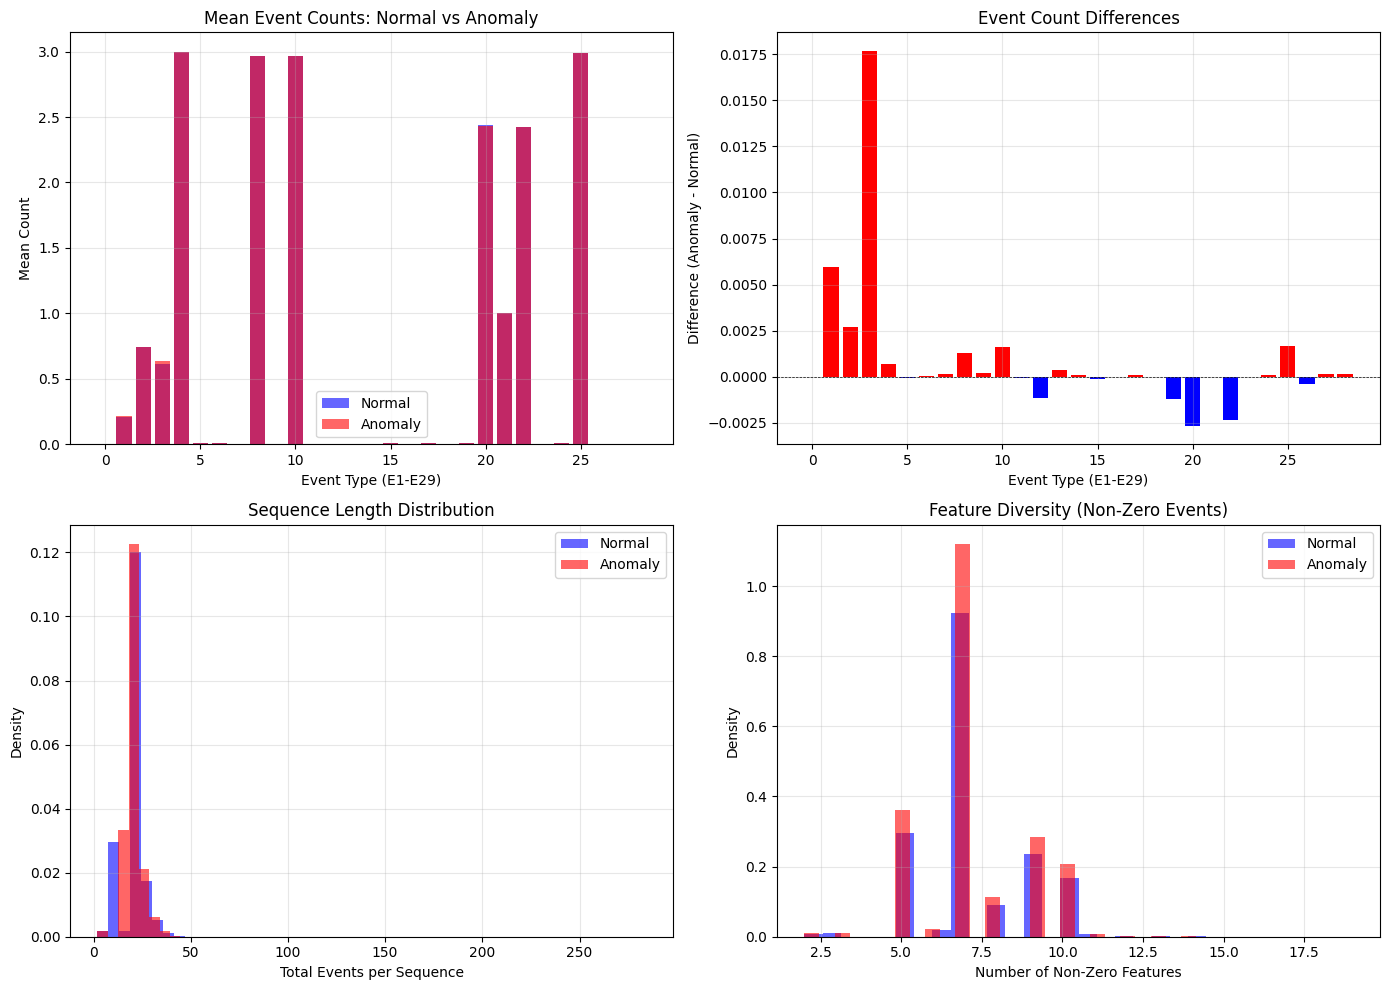

FEATURE QUALITY ANALYSIS

Normal sequences:
  Mean total events: 19.43 ± 5.15
  Mean non-zero features: 7.25 ± 1.58

Anomaly sequences:
  Mean total events: 19.45 ± 5.40
  Mean non-zero features: 7.25 ± 1.58

Separability:
  Difference in mean total events: 0.03
  Difference in mean diversity: 0.00

Statistical test (t-test for total events):
  t-statistic: -0.4809
  p-value: 6.3056e-01
  → Distributions are NOT significantly different ✗


In [6]:
# Compare normal vs anomaly statistics
import matplotlib.pyplot as plt
import numpy as np

# Get indices for normal and anomaly samples in training set
normal_idx = y_train == 0
anomaly_idx = y_train == 1

# Calculate mean event counts for each class
normal_means = X_train_occ[normal_idx].mean(axis=0)
anomaly_means = X_train_occ[anomaly_idx].mean(axis=0)

# Calculate total events per sequence
normal_totals = X_train_occ[normal_idx].sum(axis=1)
anomaly_totals = X_train_occ[anomaly_idx].sum(axis=1)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean event counts per class
axes[0, 0].bar(range(len(normal_means)), normal_means, alpha=0.6, label='Normal', color='blue')
axes[0, 0].bar(range(len(anomaly_means)), anomaly_means, alpha=0.6, label='Anomaly', color='red')
axes[0, 0].set_xlabel('Event Type (E1-E29)')
axes[0, 0].set_ylabel('Mean Count')
axes[0, 0].set_title('Mean Event Counts: Normal vs Anomaly')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Difference in means
diff = anomaly_means - normal_means
axes[0, 1].bar(range(len(diff)), diff, color=['red' if d > 0 else 'blue' for d in diff])
axes[0, 1].set_xlabel('Event Type (E1-E29)')
axes[0, 1].set_ylabel('Difference (Anomaly - Normal)')
axes[0, 1].set_title('Event Count Differences')
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Total events per sequence distribution
axes[1, 0].hist(normal_totals, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
axes[1, 0].hist(anomaly_totals, bins=50, alpha=0.6, label='Anomaly', color='red', density=True)
axes[1, 0].set_xlabel('Total Events per Sequence')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Sequence Length Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature sparsity
normal_nonzero = (X_train_occ[normal_idx] > 0).sum(axis=1)
anomaly_nonzero = (X_train_occ[anomaly_idx] > 0).sum(axis=1)
axes[1, 1].hist(normal_nonzero, bins=30, alpha=0.6, label='Normal', color='blue', density=True)
axes[1, 1].hist(anomaly_nonzero, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
axes[1, 1].set_xlabel('Number of Non-Zero Features')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Feature Diversity (Non-Zero Events)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/hdfs_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("=" * 60)
print("FEATURE QUALITY ANALYSIS")
print("=" * 60)
print(f"\nNormal sequences:")
print(f"  Mean total events: {normal_totals.mean():.2f} ± {normal_totals.std():.2f}")
print(f"  Mean non-zero features: {normal_nonzero.mean():.2f} ± {normal_nonzero.std():.2f}")

print(f"\nAnomaly sequences:")
print(f"  Mean total events: {anomaly_totals.mean():.2f} ± {anomaly_totals.std():.2f}")
print(f"  Mean non-zero features: {anomaly_nonzero.mean():.2f} ± {anomaly_nonzero.std():.2f}")

print(f"\nSeparability:")
print(f"  Difference in mean total events: {abs(anomaly_totals.mean() - normal_totals.mean()):.2f}")
print(f"  Difference in mean diversity: {abs(anomaly_nonzero.mean() - normal_nonzero.mean()):.2f}")

# Check if features are actually different
from scipy.stats import ttest_ind
print(f"\nStatistical test (t-test for total events):")
t_stat, p_value = ttest_ind(normal_totals, anomaly_totals)
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4e}")
if p_value < 0.001:
    print(f"  → Distributions are significantly different! ✓")
else:
    print(f"  → Distributions are NOT significantly different ✗")
print("=" * 60)

### 3. Train Isolation Forest

Isolation Forest is an unsupervised anomaly detection algorithm. We'll train it on the training set (without using labels) and evaluate on test set.

In [11]:
# Calculate contamination (proportion of anomalies in training set)
train_contamination = (y_train == 1).sum() / len(y_train)
print(f"Training set anomaly rate: {train_contamination:.4f} ({(y_train == 1).sum()} / {len(y_train)})")

# Initialize Isolation Forest
# Use contamination slightly higher than actual rate to be more sensitive
model = IsolationForestBaseline(
    contamination=train_contamination,  
    n_estimators=100,
    random_state=42
)

# Train (unsupervised - labels are not used)
print("\nTraining Isolation Forest...")
model.fit(X_train_occ)  # y_train is ignored in unsupervised learning

print("✓ Training complete!")

INFO:src.models.baselines:Isolation Forest initialized: n_estimators=100, contamination=0.029281002562051496
INFO:src.models.baselines:Training Isolation Forest on 345036 samples with 29 features


Training set anomaly rate: 0.0293 (10103 / 345036)

Training Isolation Forest...


INFO:src.models.baselines:Isolation Forest training complete


✓ Training complete!


## 4. Evaluate on Test Set

In [12]:
# Predict on test set
print("Evaluating on test set...")
y_pred = model.predict(X_test_occ)
y_proba = model.predict_proba(X_test_occ)

# Calculate metrics
metrics = evaluate_model(y_test, y_pred, y_proba)

# Print results
print_metrics(metrics, model_name="Isolation Forest (HDFS)")

Evaluating on test set...

Isolation Forest (HDFS) Performance
Accuracy:  0.9486
Precision: 0.0310
Recall:    0.0249
F1 Score:  0.0277
AUC:       0.4968

Confusion Matrix:
  TN: 109023  FP:   2622
  FN:   3284  TP:     84



## 5. Detailed Analysis

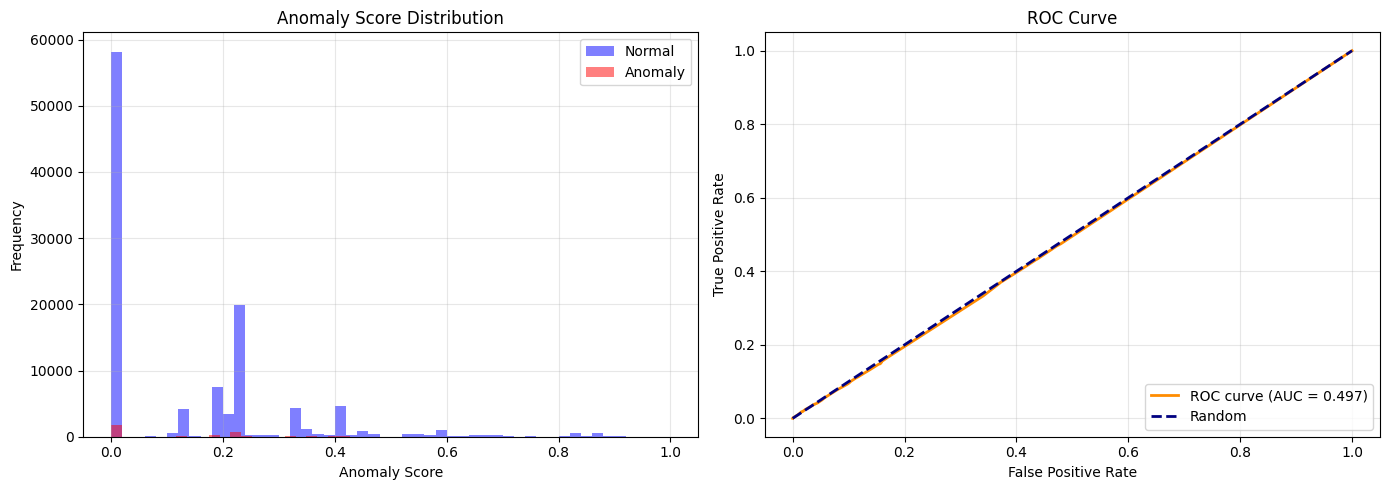

✓ Analysis plots saved to figures/hdfs_isolation_forest_analysis.png


In [13]:
# Analyze prediction distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Anomaly score distribution
axes[0].hist(y_proba[y_test == 0], bins=50, alpha=0.5, label='Normal', color='blue')
axes[0].hist(y_proba[y_test == 1], bins=50, alpha=0.5, label='Anomaly', color='red')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Anomaly Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: ROC-like visualization
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/hdfs_isolation_forest_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Analysis plots saved to figures/hdfs_isolation_forest_analysis.png")

In [14]:
# Save results to file
results = {
    'dataset': 'HDFS',
    'model': 'Isolation Forest',
    'n_estimators': 100,
    'contamination': float(train_contamination),
    'train_size': len(y_train),
    'test_size': len(y_test),
    'metrics': metrics
}

import json
with open('../results/hdfs_isolation_forest_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved to results/hdfs_isolation_forest_results.json")

# Display summary table
print("\n" + "=" * 60)
print("EXPERIMENT SUMMARY")
print("=" * 60)
print(f"Dataset:         HDFS")
print(f"Model:           Isolation Forest")
print(f"Train samples:   {len(y_train):,}")
print(f"Test samples:    {len(y_test):,}")
print(f"Features:        {X_train_occ.shape[1]}")
print(f"Contamination:   {train_contamination:.4f}")
print(f"\nTest Performance:")
print(f"  Accuracy:      {metrics['accuracy']:.4f}")
print(f"  Precision:     {metrics['precision']:.4f}")
print(f"  Recall:        {metrics['recall']:.4f}")
print(f"  F1 Score:      {metrics['f1']:.4f}")
print(f"  AUC:           {metrics['auc']:.4f}")
print("=" * 60)

✓ Results saved to results/hdfs_isolation_forest_results.json

EXPERIMENT SUMMARY
Dataset:         HDFS
Model:           Isolation Forest
Train samples:   345,036
Test samples:    115,013
Features:        29
Contamination:   0.0293

Test Performance:
  Accuracy:      0.9486
  Precision:     0.0310
  Recall:        0.0249
  F1 Score:      0.0277
  AUC:           0.4968
